# Image Classifier

In this code, I built my first image classifier on fastai to achieve state-of-the-art results. 

Every notebook starts with the following three lines; they ensure that any edits to libraries you make are reloaded here automatically, and also that any charts or images displayed are shown in this notebook.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.vision import *
from fastai.metrics import error_rate

Use smaller batch size in case memory error appears

In [3]:
# bs = 64
bs = 16   # uncomment this line if you run out of memory even after clicking Kernel->Restart

## Looking at the data

We are going to use the [Oxford-IIIT Pet Dataset](#http://www.robots.ox.ac.uk/~vgg/data/pets/) by [O. M. Parkhi et al., 2012](#http://www.robots.ox.ac.uk/~vgg/publications/2012/parkhi12a/parkhi12a.pdf) which features 12 cat breeds and 25 dogs breeds. Our model will need to learn to differentiate between these 37 distinct categories. According to their paper, the best accuracy they could get in 2012 was 59.21%, using a complex model that was specific to pet detection, with separate "Image", "Head", and "Body" models for the pet photos. Let's see how accurate we can be using deep learning!

We are going to use the untar_data function to which we must pass a URL as an argument and which will download and extract the data.

In [4]:
help(untar_data)

Help on function untar_data in module fastai.datasets:

untar_data(url:str, fname:Union[pathlib.Path, str]=None, dest:Union[pathlib.Path, str]=None, data=True, force_download=False) -> pathlib.Path
    Download `url` to `fname` if `dest` doesn't exist, and un-tgz to folder `dest`.



In [5]:
path = untar_data(URLs.PETS); path

WindowsPath('C:/Users/Ruchika/.fastai/data/oxford-iiit-pet')

In [6]:
path.ls()

[WindowsPath('C:/Users/Ruchika/.fastai/data/oxford-iiit-pet/annotations'),
 WindowsPath('C:/Users/Ruchika/.fastai/data/oxford-iiit-pet/images')]

In [7]:
path_anno = path/'annotations'
path_img = path/'images'

Before we approach the problem of image classification, it is very important to look at the data, understand the problem. Let's look at how the data is organized in directories and how the sample images and labels look like.

The main difference between the handling of image classification datasets is the way labels are stored. In this particular dataset, labels are stored in the filenames themselves. We will need to extract them to be able to classify the images into the correct categories. Fortunately, the fastai library has a handy function made exactly for this, ImageDataBunch.from_name_re gets the labels from the filenames using a regular expression.

In [8]:
fnames = get_image_files(path_img)
print(len(fnames))
fnames[:5]

7390


[WindowsPath('C:/Users/Ruchika/.fastai/data/oxford-iiit-pet/images/Abyssinian_1.jpg'),
 WindowsPath('C:/Users/Ruchika/.fastai/data/oxford-iiit-pet/images/Abyssinian_10.jpg'),
 WindowsPath('C:/Users/Ruchika/.fastai/data/oxford-iiit-pet/images/Abyssinian_100.jpg'),
 WindowsPath('C:/Users/Ruchika/.fastai/data/oxford-iiit-pet/images/Abyssinian_101.jpg'),
 WindowsPath('C:/Users/Ruchika/.fastai/data/oxford-iiit-pet/images/Abyssinian_102.jpg')]

In [9]:
np.random.seed(2)
pat = r'/([^/]+)_\d+.jpg$'

In [10]:
data = ImageDataBunch.from_name_re(path_img, fnames, pat, ds_tfms=get_transforms(), size=224, bs=bs
                                  ).normalize(imagenet_stats)

In [11]:
data

ImageDataBunch;

Train: LabelList (5912 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Abyssinian,Abyssinian,Abyssinian,Abyssinian,Abyssinian
Path: C:\Users\Ruchika\.fastai\data\oxford-iiit-pet\images;

Valid: LabelList (1478 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
american_pit_bull_terrier,staffordshire_bull_terrier,Abyssinian,Egyptian_Mau,Maine_Coon
Path: C:\Users\Ruchika\.fastai\data\oxford-iiit-pet\images;

Test: None

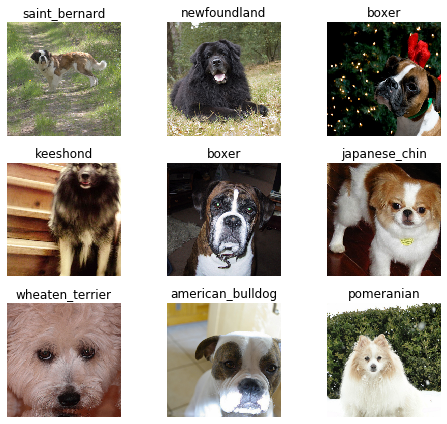

In [12]:
data.show_batch(rows=3, figsize=(7,6))

In [13]:
print(data.classes)
len(data.classes),data.c

['Abyssinian', 'Bengal', 'Birman', 'Bombay', 'British_Shorthair', 'Egyptian_Mau', 'Maine_Coon', 'Persian', 'Ragdoll', 'Russian_Blue', 'Siamese', 'Sphynx', 'american_bulldog', 'american_pit_bull_terrier', 'basset_hound', 'beagle', 'boxer', 'chihuahua', 'english_cocker_spaniel', 'english_setter', 'german_shorthaired', 'great_pyrenees', 'havanese', 'japanese_chin', 'keeshond', 'leonberger', 'miniature_pinscher', 'newfoundland', 'pomeranian', 'pug', 'saint_bernard', 'samoyed', 'scottish_terrier', 'shiba_inu', 'staffordshire_bull_terrier', 'wheaten_terrier', 'yorkshire_terrier']


(37, 37)

# Training: resnet34

Now we will start training our model. 

We will use a convolutional neural network backbone and a fully connected head with a single hidden layer as a classifier. We will take images as input and  predicted probability as output for each of the categories (in this case, it will have 37 outputs).

We will train for 4 epochs (4 cycles through all our data)

In [14]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

In [15]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [16]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,0.927573,0.385004,0.119756,02:44
1,0.669510,0.398980,0.102165,02:54
2,0.518018,0.265117,0.075778,02:54
3,0.352857,0.245310,0.074425,02:53


In [17]:
learn.save('stage-1')

# Results
Let's see what results we have got.

We will first see which were the categories that the model most confused with one another. We will try to see if what the model predicted was reasonable or not.

In this case the mistakes look reasonable (none of the mistakes seems obviously naive). This is an indicator that our classifier is working correctly.

Furthermore, when we plot the confusion matrix, we can see that the distribution is heavily skewed: the model makes the same mistakes over and over again but it rarely confuses other categories. This suggests that it just finds it difficult to distinguish some specific categories between each other; this is normal behaviour.

In [18]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

In [21]:
# Validation losses
len(losses)

1478

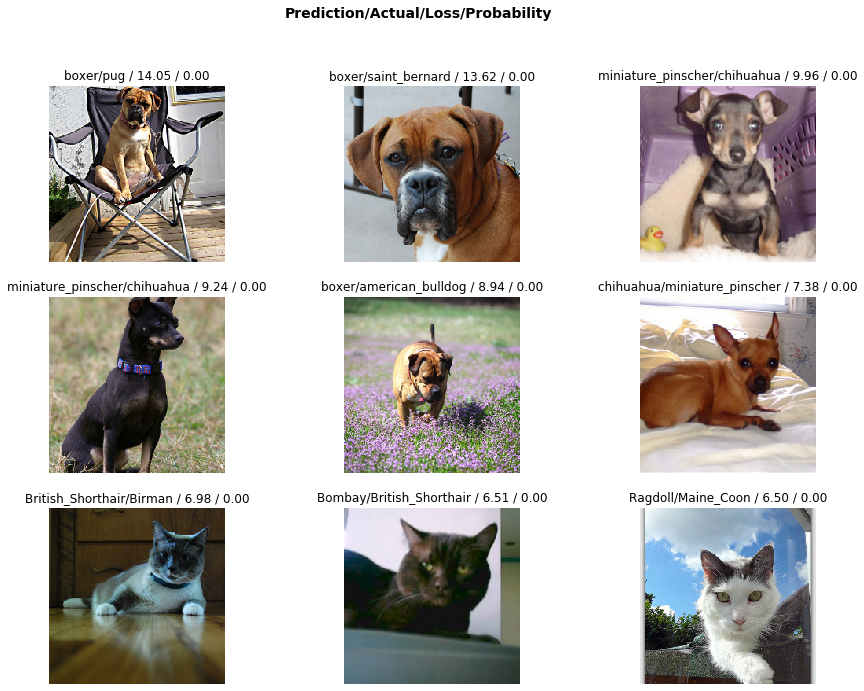

In [22]:
interp.plot_top_losses(9, figsize=(15,11))

In [23]:
doc(interp.plot_top_losses)

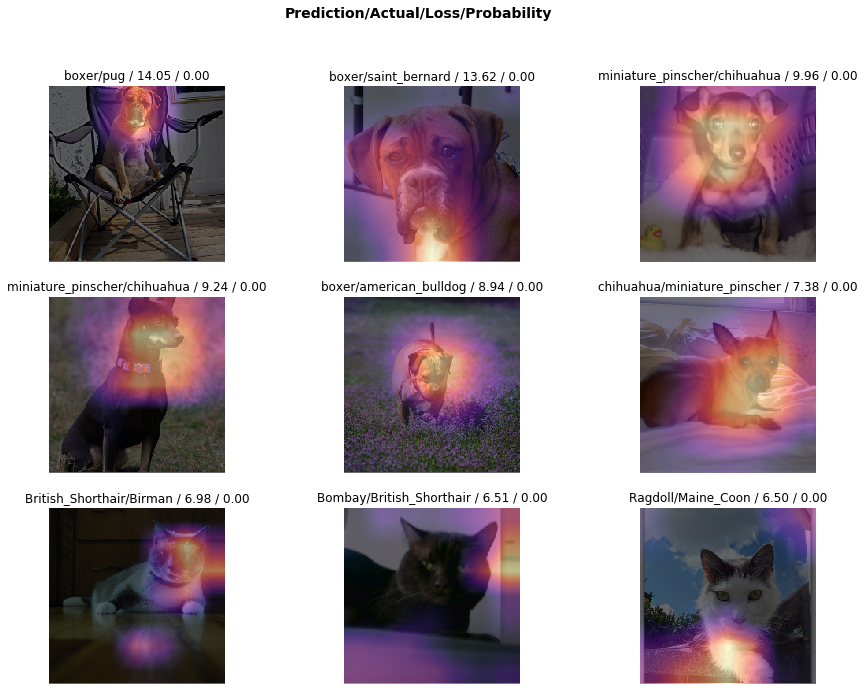

In [25]:
interp.plot_top_losses(9, figsize=(15,11), heatmap=True)

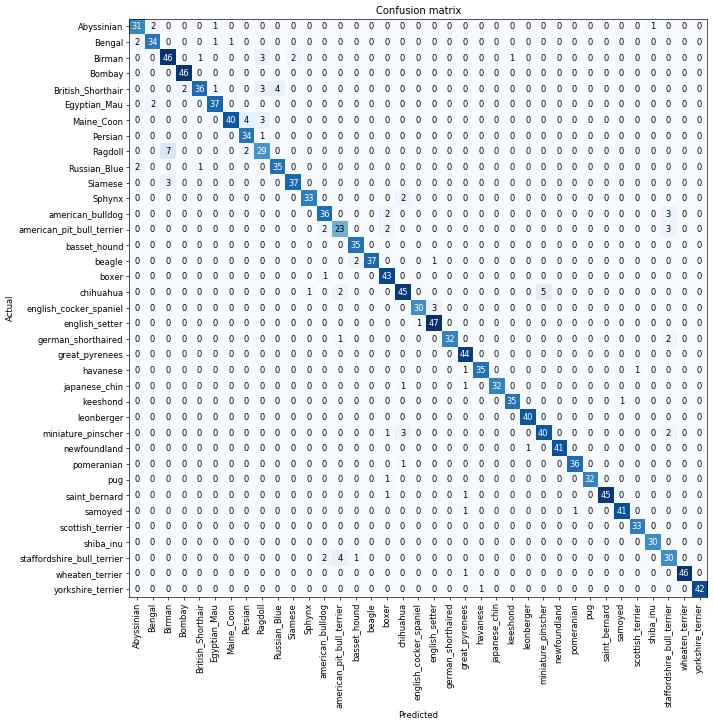

In [26]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [27]:
interp.most_confused(min_val=2)

[('Ragdoll', 'Birman', 7),
 ('chihuahua', 'miniature_pinscher', 5),
 ('British_Shorthair', 'Russian_Blue', 4),
 ('Maine_Coon', 'Persian', 4),
 ('staffordshire_bull_terrier', 'american_pit_bull_terrier', 4),
 ('Birman', 'Ragdoll', 3),
 ('British_Shorthair', 'Ragdoll', 3),
 ('Maine_Coon', 'Ragdoll', 3),
 ('Siamese', 'Birman', 3),
 ('american_bulldog', 'staffordshire_bull_terrier', 3),
 ('american_pit_bull_terrier', 'staffordshire_bull_terrier', 3),
 ('english_cocker_spaniel', 'english_setter', 3),
 ('miniature_pinscher', 'chihuahua', 3),
 ('Abyssinian', 'Bengal', 2),
 ('Bengal', 'Abyssinian', 2),
 ('Birman', 'Siamese', 2),
 ('British_Shorthair', 'Bombay', 2),
 ('Egyptian_Mau', 'Bengal', 2),
 ('Ragdoll', 'Persian', 2),
 ('Russian_Blue', 'Abyssinian', 2),
 ('Sphynx', 'chihuahua', 2),
 ('american_bulldog', 'boxer', 2),
 ('american_pit_bull_terrier', 'american_bulldog', 2),
 ('american_pit_bull_terrier', 'boxer', 2),
 ('beagle', 'basset_hound', 2),
 ('chihuahua', 'american_pit_bull_terrier',

# Unfreezing, fine-tuning, and learning rates

Since our model is working as we expect it to, we will unfreeze our model and train some more.

In [28]:
learn.unfreeze()

In [29]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,error_rate,time
0,0.933477,0.400811,0.112314,03:16


In [30]:
learn.load('stage-1');

In [34]:
learn.lr_find()

epoch,train_loss,valid_loss,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


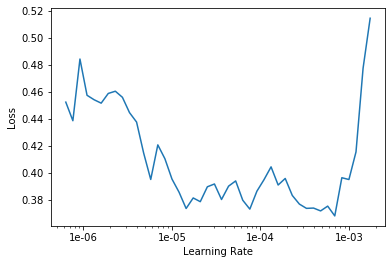

In [35]:
learn.recorder.plot()

In [36]:
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-5,1e-3))

epoch,train_loss,valid_loss,error_rate,time
0,0.714400,0.396231,0.109608,03:13
1,0.415344,0.257061,0.075778,03:30


# Training: resnet50

Now we will train in the same way as before but with one caveat: instead of using resnet34 as our backbone we will use resnet50 (resnet34 is a 34 layer residual network while resnet50 has 50 layers).

Basically, resnet50 usually performs better because it is a deeper network with more parameters. Let's see if we can achieve a higher performance here. To help it along, let's us use larger images too, since that way the network can see more detail. We reduce the batch size a bit since otherwise this larger network will require more GPU memory.

In [39]:
data = ImageDataBunch.from_name_re(path_img, fnames, pat, ds_tfms=get_transforms(),
                                   size=299, bs=bs//2).normalize(imagenet_stats)

In [40]:
learn = cnn_learner(data, models.resnet50, metrics=error_rate)

epoch,train_loss,valid_loss,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


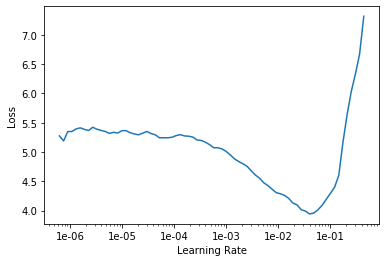

In [41]:
learn.lr_find()
learn.recorder.plot()

In [42]:
learn.fit_one_cycle(8)

epoch,train_loss,valid_loss,error_rate,time
0,0.851568,0.394493,0.112314,06:29
1,0.853319,0.374696,0.108254,07:02
2,0.704797,0.293942,0.087280,07:11
3,0.683930,0.303722,0.085250,06:50
4,0.454970,0.242777,0.072395,07:37
5,0.460974,0.219135,0.065629,07:34
6,0.320499,0.196955,0.056157,09:10
7,0.270639,0.202712,0.064276,10:32


In [43]:
learn.save('stage-1-50')

It's astonishing that it's possible to recognize pet breeds so accurately! Let's see if full fine-tuning helps:

In [44]:
learn.unfreeze()
learn.fit_one_cycle(3, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.295671,0.207420,0.055480,12:32
1,0.313613,0.196711,0.058863,13:08
2,0.278391,0.182360,0.057510,13:42


In [45]:
learn.load('stage-1-50');

In [46]:
interp = ClassificationInterpretation.from_learner(learn)

In [48]:
interp.most_confused(min_val=2)

[('Egyptian_Mau', 'Bengal', 7),
 ('Ragdoll', 'Birman', 7),
 ('american_pit_bull_terrier', 'staffordshire_bull_terrier', 4),
 ('Bengal', 'Maine_Coon', 3),
 ('Ragdoll', 'Maine_Coon', 3),
 ('Russian_Blue', 'British_Shorthair', 3),
 ('american_bulldog', 'boxer', 3),
 ('beagle', 'basset_hound', 3),
 ('chihuahua', 'miniature_pinscher', 3),
 ('miniature_pinscher', 'american_pit_bull_terrier', 3),
 ('Abyssinian', 'Russian_Blue', 2),
 ('Bengal', 'Abyssinian', 2),
 ('Bengal', 'Egyptian_Mau', 2),
 ('Ragdoll', 'Persian', 2),
 ('Russian_Blue', 'Abyssinian', 2),
 ('Siamese', 'Birman', 2),
 ('american_pit_bull_terrier', 'american_bulldog', 2),
 ('american_pit_bull_terrier', 'miniature_pinscher', 2),
 ('basset_hound', 'beagle', 2),
 ('leonberger', 'keeshond', 2),
 ('staffordshire_bull_terrier', 'american_bulldog', 2),
 ('staffordshire_bull_terrier', 'american_pit_bull_terrier', 2)]